# Greetings! 
> You received this jupyter notebook as we believe this can be a great fit. <br>
> The goal of this notebook is to understand our challenges better <br> and assess your proficiency in python & pandas.

### Several remarks:
* You are welcome to use the internet, consult, and use any available sources.
* There is no time limit, and we do not monitor any versioning or pace. Take your time and have fun.
* The notebook should take up to two hours. If it takes more than that, please reach out.
We tried to create an intriguing assignment. If you have any feedback - we'll be happy to hear.
* A text cell decorated with "👷" will be followed by a code cell you are welcome to fill in.

# **The products recommendation notebook**
The data at hand represents 12,000 bank clients and their monthly financial status. 
<br> The data is featured as a tabular schema, where each row contains 48 features.
>The first 24 features are client-level entities such as age, residence country, and the joining channel.
<br>The last 24 features are the **products** the client owns in a specified month (`Status_Dt`).

Our task is to *forecast* which products a client will add or remove next month, given that we have all past information on the client.

# Logistics

In [ ]:
# Download and extract the dataset
!pip install --upgrade gdown tsfresh
!rm -rf sample_data
!mkdir data & gdown 1DkOvf0LaRgCVfLEtHXr5ztaHhGN4-tDu -O data/features_products.zip
!unzip data/features_products.zip -d data/features_products
!find . -name "*.zip" ! -iname features_products.zip | while read filename; do unzip -o -d "`dirname "$filename"`" "$filename"; done;
!find . -name "*.zip" -delete

mkdir: cannot create directory ‘data’: File exists
Downloading...
From: https://drive.google.com/uc?id=1DkOvf0LaRgCVfLEtHXr5ztaHhGN4-tDu
To: /content/data/features_products.zip
100% 240M/240M [00:01<00:00, 201MB/s]
Archive:  data/features_products.zip
  inflating: data/features_products/sample_submission.csv.zip  
  inflating: data/features_products/test_ver2.csv.zip  
  inflating: data/features_products/train_ver2.csv.zip  
Archive:  ./data/features_products/train_ver2.csv.zip
  inflating: ./data/features_products/train_ver2.csv  
Archive:  ./data/features_products/sample_submission.csv.zip
  inflating: ./data/features_products/sample_submission.csv  
Archive:  ./data/features_products/test_ver2.csv.zip
  inflating: ./data/features_products/test_ver2.csv  


In [ ]:
# Import libraries and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
import tsfresh
color = sns.color_palette()
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)
import warnings
warnings.filterwarnings("ignore")


Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Sample the dataset (We only want to experiment with the data).
limit_rows   = 7000000
df           = pd.read_csv("data/features_products/train_ver2.csv",dtype={"sexo":str,
                                                    "ind_nuevo":str,
                                                    "ult_fec_cli_1t":str,
                                                    "indext":str},
                                                     nrows=limit_rows)


In [ ]:
# The original schema was in Spanish. We will rename the columns for readability.
df.columns = ['Status_Dt', 'Cust_ID', 'Emp_Status', 'Cust_Ctry', 'Cust_Sex', 'Age', 'Join_Dt',
                'Is_New_Cust', 'Cust_Since', 'Relship_Status','Lst_Dt_Primary_Cust', 'Cust_Type_Mth_Beg', 
                'Cust_Relship_Type_Mth_Beg', 'Residence_Ctry', 'Is_Foreigner', 'Is_Spouse_Emp', 'Join_Channel', 'Deceased_Flg', 
                'Address_Type', 'Cust_Province_Cd', 'Cust_Province_Name', 'Cust_Active_Status', 'Gross_HHLD_Income',
                'Cust_Segment', 'Savings_Acct', 'Guarantees', 'Cur_Acct', 'Derivative_Acct', 'Payroll_Acct',
                'Junior_Acct', 'Mas_Particular_Acct', 'Particular_Acct', 'Particular_Plus_Acct', 'Short_Term_Deposits',
                'Med_Term_Deposits', 'Long_Term_Deposits', 'e-Acct', 'Funds', 'Mortgage', 'Pension1', 'Loans',
                'Taxes', 'Credit_Card', 'Securities', 'Home_Acct', 'Payroll', 'Pension2', 'Direct_Debit']

# Sample the dataset (We only want to experiment with the data).     
unique_ids   = pd.Series(df["Cust_ID"].unique())
limit_people = int(1.2e4)
unique_id    = unique_ids.sample(n=limit_people)
df           = df[df.Cust_ID.isin(unique_id)]

In [ ]:
# Cast relevant data types
date_attribs = ['Status_Dt', 'Join_Dt', 'Lst_Dt_Primary_Cust']
for attrib in date_attribs:
    df[attrib] = pd.to_datetime(df[attrib],format="%Y-%m-%d")
numeric_attribs = ['Age', 'Is_New_Cust', 'Cust_Since', 'Relship_Status', 'Address_Type', 'Cust_Active_Status']
for attrib in numeric_attribs:
    df[attrib] = pd.to_numeric(df[attrib], downcast='integer',errors='coerce')

# Exploratory Data Analysis 👷

### The task in this phase is to analyze the data.
#### Think of at least one EDA plot that helps understand the underlying statistics. Explain your choice.
*Remember - The goal is to predict which items customers will add in the following month.*

> You are not obligated to submit all plots and analyses you perform.
<br>Try to understand the data as good as possible.


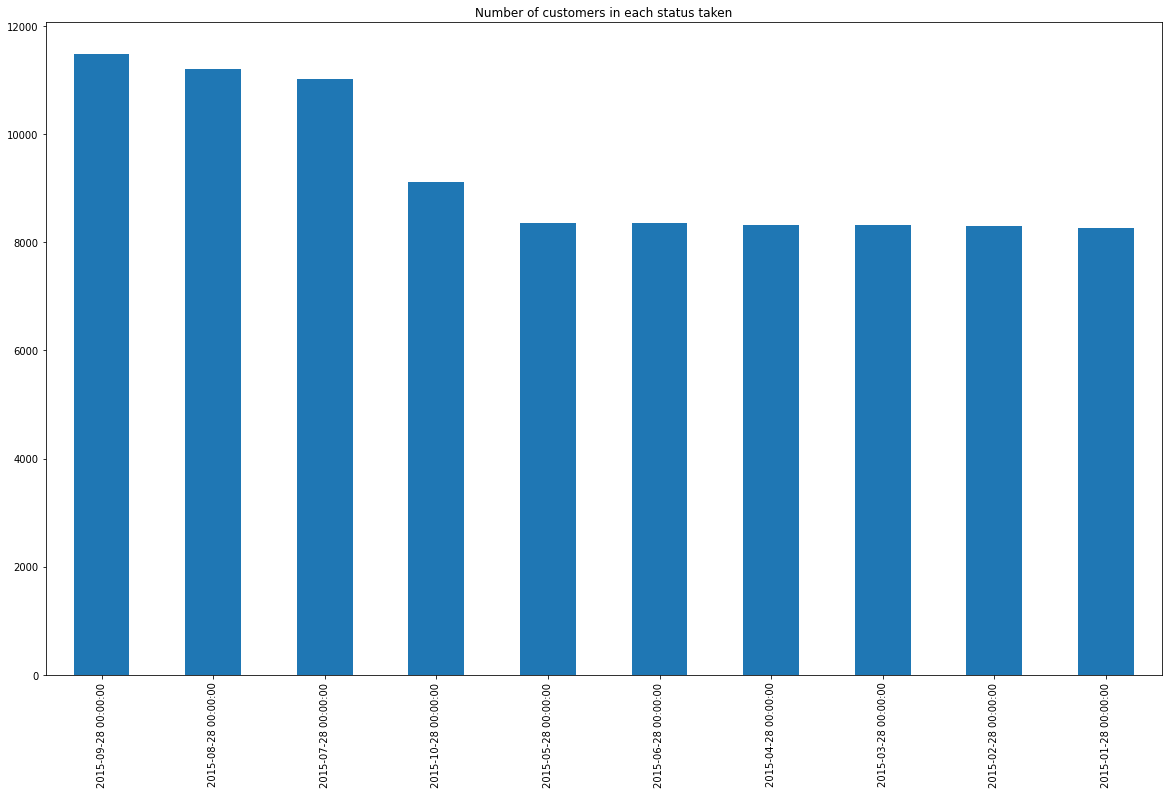

In [ ]:
df['Status_Dt'].value_counts().plot(kind='bar',title='Number of customers in each status taken')
# look like status are taken every month at the 28'th.

In [ ]:
df.columns[:24] # customer columns

Index(['Status_Dt', 'Cust_ID', 'Emp_Status', 'Cust_Ctry', 'Cust_Sex', 'Age',
       'Join_Dt', 'Is_New_Cust', 'Cust_Since', 'Relship_Status',
       'Lst_Dt_Primary_Cust', 'Cust_Type_Mth_Beg', 'Cust_Relship_Type_Mth_Beg',
       'Residence_Ctry', 'Is_Foreigner', 'Is_Spouse_Emp', 'Join_Channel',
       'Deceased_Flg', 'Address_Type', 'Cust_Province_Cd',
       'Cust_Province_Name', 'Cust_Active_Status', 'Gross_HHLD_Income',
       'Cust_Segment'],
      dtype='object')

In [ ]:
# adding 'Prod' prefix
df.rename(columns=dict(zip(df.columns[-24:],list(map(lambda x:f"Prod_{x}",df.columns[-24:])))),inplace=True)
df.columns[-24:] # product columns

Index(['Prod_Savings_Acct', 'Prod_Guarantees', 'Prod_Cur_Acct',
       'Prod_Derivative_Acct', 'Prod_Payroll_Acct', 'Prod_Junior_Acct',
       'Prod_Mas_Particular_Acct', 'Prod_Particular_Acct',
       'Prod_Particular_Plus_Acct', 'Prod_Short_Term_Deposits',
       'Prod_Med_Term_Deposits', 'Prod_Long_Term_Deposits', 'Prod_e-Acct',
       'Prod_Funds', 'Prod_Mortgage', 'Prod_Pension1', 'Prod_Loans',
       'Prod_Taxes', 'Prod_Credit_Card', 'Prod_Securities', 'Prod_Home_Acct',
       'Prod_Payroll', 'Prod_Pension2', 'Prod_Direct_Debit'],
      dtype='object')

In [ ]:
###### Your Code Here ######
(df.isna().sum() / df.isna().count()).sort_values(ascending=False)

Is_Spouse_Emp                0.999881
Lst_Dt_Primary_Cust          0.998695
Gross_HHLD_Income            0.173156
Cust_Segment                 0.016842
Join_Channel                 0.016594
Cust_Type_Mth_Beg            0.014114
Cust_Relship_Type_Mth_Beg    0.014114
Cust_Province_Name           0.007451
Cust_Province_Cd             0.007451
Deceased_Flg                 0.003213
Residence_Ctry               0.003213
Cust_Active_Status           0.003213
Address_Type                 0.003213
Is_Foreigner                 0.003213
Relship_Status               0.003213
Cust_Since                   0.003213
Is_New_Cust                  0.003213
Join_Dt                      0.003213
Age                          0.003213
Cust_Sex                     0.003213
Cust_Ctry                    0.003213
Emp_Status                   0.003213
Prod_Pension2                0.001736
Prod_Payroll                 0.001736
Prod_Taxes                   0.000000
Prod_Funds                   0.000000
Prod_Mortgag

In [ ]:
df.shape

(92743, 48)

In [ ]:
df.nunique()
# look like: 
#.    - a 'snapshot' of the system was taken 10 times (Status_Dt=10) -> lets check the patern of customer appears in all, since there is only 93096 records, some are missing)  
#.    - all product tags a booleans
#.    - Age is a float
#.    - Categorial Features: Emp_Status,Cust_Segment
#.    - Boolean Features: Cust_Sex,Is_New_Cust,
#.    - Is_New_Cust - > what considet as 'new' when this feature turns from True to False
#.    - Is_Spouse_Emp -> why there is only one value, probrbly, we should fillna(False)
#.    - Deceased_Flg -> when true, all products should be 'False'
#.    - Features to check their distribution: Gross_HHLD_Income,
#.    - when Cust_Relship_Type_Mth_Beg!=Relship_Status should be a strong feature :| (check why unique(Cust_Relship_Type_Mth_Beg)==4 and (unqiue(Relship_Status)==2))
#.    - 


Status_Dt                       10
Cust_ID                      12000
Emp_Status                       4
Cust_Ctry                       26
Cust_Sex                         2
Age                            107
Join_Dt                       3958
Is_New_Cust                      2
Cust_Since                     249
Relship_Status                   2
Lst_Dt_Primary_Cust             40
Cust_Type_Mth_Beg               10
Cust_Relship_Type_Mth_Beg        4
Residence_Ctry                   2
Is_Foreigner                     2
Is_Spouse_Emp                    1
Join_Channel                   106
Deceased_Flg                     2
Address_Type                     1
Cust_Province_Cd                52
Cust_Province_Name              52
Cust_Active_Status               2
Gross_HHLD_Income             9427
Cust_Segment                     3
Prod_Savings_Acct                1
Prod_Guarantees                  1
Prod_Cur_Acct                    2
Prod_Derivative_Acct             2
Prod_Payroll_Acct   

In [ ]:
# fix labels
labels = ['Prod_Payroll','Prod_Pension2']
df[labels].fillna(1,inplace=True) # we prefer false positive

# convert all labels to binary
for col in df.filter(like="Prod").columns:
  df[col] = pd.to_numeric(df[col], downcast='integer',errors='coerce')

In [ ]:
df['Emp_Status'].unique()
# no idea what each one mean. let create new catregoriy 

array(['N', nan, 'A', 'F', 'B'], dtype=object)

In [ ]:
df['Emp_Status'] = df['Emp_Status'].fillna("UNKNOWN")
df['Emp_Status'].unique()

array(['N', 'UNKNOWN', 'A', 'F', 'B'], dtype=object)

In [ ]:
df['Cust_Segment'].unique()
# no idea what each one means

array(['03 - UNIVERSITARIO', '02 - PARTICULARES', nan, '01 - TOP'],
      dtype=object)

In [ ]:
df['Cust_Segment'] = df['Cust_Segment'].fillna("UNCLASSIFIED")
df['Cust_Segment'].unique()

array(['03 - UNIVERSITARIO', '02 - PARTICULARES', 'UNCLASSIFIED',
       '01 - TOP'], dtype=object)

In [ ]:
# convert to boolean
df['Is_Spouse_Emp'] = df['Is_Spouse_Emp'].map({np.nan:1,"N":0})
df['Prod_Direct_Debit']

20         0
60         0
110        0
159        0
215        1
          ..
6999209    0
6999485    0
6999767    0
6999777    0
6999968    0
Name: Prod_Direct_Debit, Length: 92743, dtype: int8

In [ ]:
# since we would like to predict next month and some has no next month, we will drop them.
reports_for_cust = df.groupby('Cust_ID').Status_Dt.count()
reports_for_cust.value_counts()

10    6097
9     2070
4     1862
3      952
1      430
2      304
5       93
6       71
8       63
7       58
Name: Status_Dt, dtype: int64

In [ ]:
no_next_month_to_drop = reports_for_cust[reports_for_cust == 1].index
df = df[~df.Cust_ID.isin(no_next_month_to_drop)]
df.head()

,Status_Dt,Cust_ID,Emp_Status,Cust_Ctry,Cust_Sex,Age,Join_Dt,Is_New_Cust,Cust_Since,Relship_Status,...,Prod_Mortgage,Prod_Pension1,Prod_Loans,Prod_Taxes,Prod_Credit_Card,Prod_Securities,Prod_Home_Acct,Prod_Payroll,Prod_Pension2,Prod_Direct_Debit
20,2015-01-28,1050582,N,ES,V,28.0,2012-08-10,0.0,35.0,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
60,2015-01-28,1050634,N,ES,H,55.0,2012-08-10,0.0,35.0,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
110,2015-01-28,1050501,N,ES,V,63.0,2012-08-10,0.0,35.0,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
159,2015-01-28,1050885,N,ES,H,24.0,2012-08-10,0.0,35.0,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
215,2015-01-28,1050911,N,ES,H,29.0,2012-08-10,0.0,35.0,1.0,...,0,0,0,0,1,0,0,0.0,0.0,1


In [ ]:
df.groupby('Cust_ID')['Gross_HHLD_Income'].apply(lambda x:x.isna().sum()).value_counts()
# ok, there missing value is across couple types, lets check the if the customer show in all status_dt before

0     9499
10    1006
9      326
4      313
2      174
3      167
6       27
5       25
8       20
7       13
Name: Gross_HHLD_Income, dtype: int64

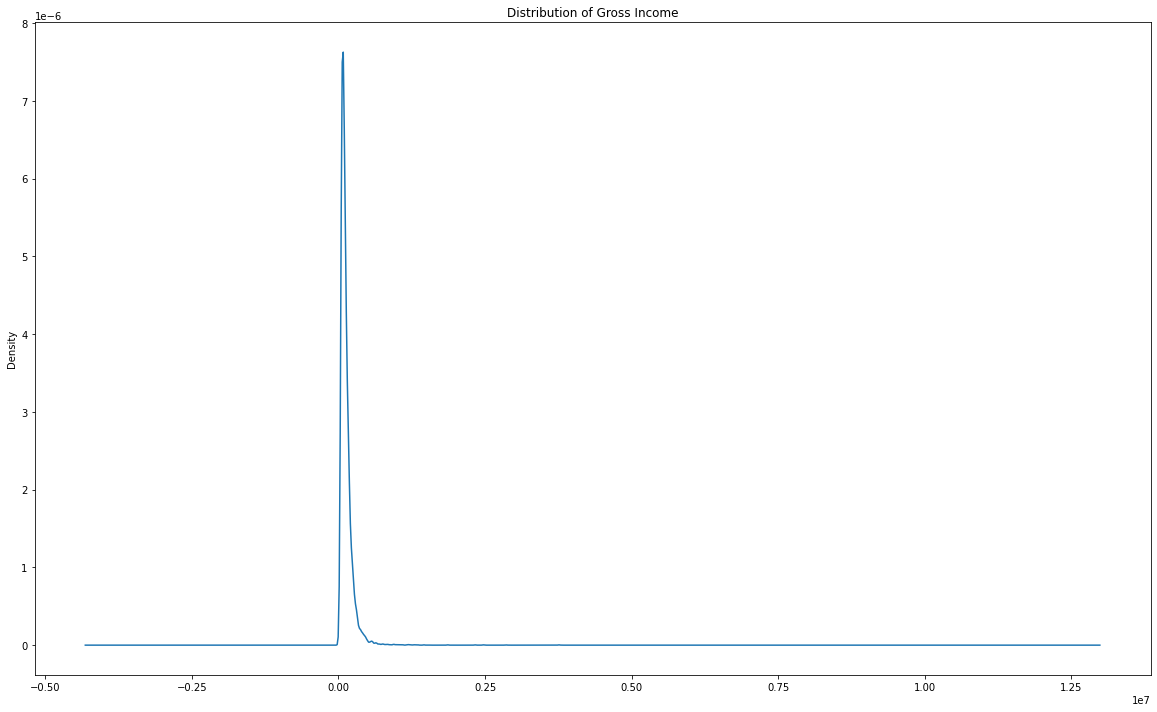

In [ ]:
df['Gross_HHLD_Income'].plot(kind='density',title="Distribution of Gross Income")
# Assuming 'Income' is the change in the balance between to dates, otherwize income can't be negative. 

In [ ]:
# let fill the values we can conclude from last vector, assume noting changed.
df = df.groupby('Cust_ID').apply(lambda x:x.sort_values('Status_Dt').fillna(method='backfill'))

# Let's get down, let's get down to business! 🕺💃 👷

After understanding our data better, we would like to train a model to predict the following products a client is about to add or remove.

The development will be segmented into *three* steps.

1.   Create a label vector for each month:
<br>The label vector for each `<client, date>` is the *difference* between the products the client holds in `<date>` and the products of the same client in the consecutive month.<br><br>

2.   Generate temporal features to extend the static features each client has. <br> We will use a **rolling-window** mechanism to couple `k` consecutive months of the same user to generate time-series based features.
<br>We will use the `tsfresh` library as our automatic feature-generation tool. <br>`tsfresh` has a tailor-maid function for that ([roll_time_series](https://tsfresh.readthedocs.io/en/latest/api/tsfresh.utilities.html#tsfresh.utilities.dataframe_functions.roll_time_series)).

3. Use any relevant classification algorithm to predict the shift between consecutive months.



## Create labels

In [ ]:
# Create a label feature vector per <Cust_ID,Status_Dt>
# The label vector will be of length 27 and will represent the change in products between consecutive months
# Create a `next_data` dataframe with the following columns:
# ['Cust_ID','Status_Dt', 'Status_Dt_shifted', ... 24 difference columns ...]
# The name of each column will be the original column name with the added suffix '_change`
# e.g `Funds_change`.

###### Your Code Here ######

# shift the date, keep the original date as 'shifted'
originl_df = df.filter(regex='(Prod|Cust_ID|Status_Dt)')
shifted_df = originl_df.rename(columns={"Status_Dt":'Status_Dt_shifted'})
shifted_df['Status_Dt'] = shifted_df['Status_Dt_shifted'] - pd.DateOffset(months=1)

# merge the data
next_data = pd.merge(originl_df,shifted_df,on=['Cust_ID','Status_Dt'],how='inner',suffixes=('', '_change'))

# meaure the change
drop = list()
for col in next_data.filter(like="_change").columns:
    print(col)
    before_name = col.split("_change")[0]
    goal_name = before_name.split('Prod_')[1]

    next_data[f'{goal_name}_change'] = next_data[before_name] - next_data[col]

    drop.extend([before_name,col])

next_data = next_data.drop(columns=drop)


Prod_Savings_Acct_change
Prod_Guarantees_change
Prod_Cur_Acct_change
Prod_Derivative_Acct_change
Prod_Payroll_Acct_change
Prod_Junior_Acct_change
Prod_Mas_Particular_Acct_change
Prod_Particular_Acct_change
Prod_Particular_Plus_Acct_change
Prod_Short_Term_Deposits_change
Prod_Med_Term_Deposits_change
Prod_Long_Term_Deposits_change
Prod_e-Acct_change
Prod_Funds_change
Prod_Mortgage_change
Prod_Pension1_change
Prod_Loans_change
Prod_Taxes_change
Prod_Credit_Card_change
Prod_Securities_change
Prod_Home_Acct_change
Prod_Payroll_change
Prod_Pension2_change
Prod_Direct_Debit_change


In [ ]:
# Because we only care about behavioural changes, we filter rows with no product change in the consecutive month.
trainable_objects = next_data.iloc[:,3:].any(axis=1).to_numpy().nonzero()[0]
next_data_relevant = next_data.iloc[trainable_objects]

# >> you are filtering the data by the label, not sure i'm getting this.

## Create features

In [ ]:
client_level_features = df.loc[:,~df.columns.str.startswith("Prod_")]

In [ ]:
# We will train our model only on users with at least four months of seniority.
# Filter out all clients with less than four months of seniority.
# You can assume no client left the bank and then returned.
###### Your Code Here ######

# >> it is not clear you are talking here about the client level features.
customers_with_more_then_three_vectors = (client_level_features['Cust_ID'].value_counts() > 3).index.values
client_level_features = client_level_features.loc[client_level_features.Cust_ID.isin(customers_with_more_then_three_vectors),:]

In [ ]:
# Using the roll_time_series function, create a sliding window of **exactly** four months for each <client,date>.
# <client, date> without sufficient history will be filtered out.
# The rolled dataframe will be called `rolled`

from tsfresh.utilities.dataframe_functions import roll_time_series
###### Your Code Here ######

rolled = roll_time_series(client_level_features, column_id="Cust_ID", column_sort="Status_Dt",min_timeshift=3,max_timeshift=4) 


Rolling: 100%|██████████| 10/10 [02:46<00:00, 16.69s/it]


In [ ]:
# We will take only the numeric attribiutes of the rolled dataframe and filter nans
rolled = pd.concat((rolled[['id','Status_Dt']],rolled.select_dtypes([np.number])),axis=1).dropna().drop('Cust_ID',axis=1)

In [ ]:
# Create the 'id' column for the next_data_relevant dataframe and join it with the `rolled` dataframe.

###### Your Code Here ######
next_data_relevant['id'] = list(zip(next_data_relevant.Cust_ID, next_data_relevant.Status_Dt)) # 
relevant_rolled = pd.merge(rolled,next_data_relevant,on='id',how='inner')

In [ ]:
# We will use the `tsfresh` library to autogenerate time-series features.
# The code is provided for you, but you are welcome to read more about `extract_features`.

# We filter the labels from `relevant_rolled` and drop redundant columns
relevant_rolled = relevant_rolled.loc[:,~relevant_rolled.columns.str.endswith('change')].drop(['Cust_ID','Status_Dt_y','Status_Dt_shifted'],axis=1)

from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters
settings = MinimalFCParameters()
features = extract_features(relevant_rolled, column_id="id", column_sort="Status_Dt_x", default_fc_parameters=settings)


features = features.reset_index().rename(columns={'level_0':'Cust_ID','level_1':'Status_Dt'})

Feature Extraction: 100%|██████████| 25110/25110 [00:15<00:00, 1626.17it/s]


In [ ]:
# 1. Merge the time-series features with the original features from the basic dataframe
# 2. Merge the features with the labels (the products difference vector)
# Call the final df `features_labels`
# Sanity: The columns axis should be of length 394

###### Your Code Here ######
client_level_features = df.loc[:,~df.columns.str.startswith("Prod_")]

only_features = pd.merge(client_level_features,features,on=['Status_Dt','Cust_ID'])
features_labels = pd.merge(only_features,next_data_relevant,on=['Status_Dt','Cust_ID'])

## Modeling

In [ ]:
# Beware! a random train,test split will not work here, as we will leak data to future occurances.
# We will take the last month as our testing data, and the rest as train.

last_month_in_db = np.sort([d[1] for d in features_labels.id.values])[-1]
features_labels['last_month'] = [d[1] for d in features_labels.id.values]
train, test = features_labels[features_labels['last_month'] != last_month_in_db], features_labels[features_labels['last_month'] == last_month_in_db]

## Training

In [ ]:
# We provide below a helper to preprocess the training features before entering to the model.
def prepare_for_model(df):
  features = df.loc[:,~df.columns.str.endswith('_change')].drop(['Cust_ID','Status_Dt'],axis=1)
  labels = df.loc[:,df.columns.str.endswith('_change')]
  features.loc[:,features.dtypes=='object'] = features.loc[:,features.dtypes=='object'].astype('category')

  features['Join_year'] = pd.DatetimeIndex(features['Join_Dt']).year
  features['Join_month'] = pd.DatetimeIndex(features['Join_Dt']).month
  features['Join_day'] = pd.DatetimeIndex(features['Join_Dt']).day
  features = features.drop(['Join_Dt','Status_Dt_shifted','id','Lst_Dt_Primary_Cust','last_month'],axis=1)
  features['Cust_Type_Mth_Beg'] = features['Cust_Type_Mth_Beg'].astype(float).astype(int)

  from sklearn.preprocessing import LabelEncoder
  for column in features.columns[features.dtypes == 'category']:
    features[column] = LabelEncoder().fit_transform(features[column])
  return features, labels

train_features, train_labels = prepare_for_model(train)
test_features, test_labels = prepare_for_model(test)

In [ ]:
! pip install xgboost

### It's the final countdown 🍒👷

In [ ]:
# There are several months where a client changed more than one item.
# Thus we are looking at a multioutput classification problem.
# Use any algorithm/ platform/ library you desire and train the above `train_features, train_labels`.
# Test on test_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier
import xgboost
###### Your Code Here ######
# fitting 
multioutput = MultiOutputClassifier(xgboost.XGBClassifier()).fit(train_features, train_labels)  
yhat = multioutput.predict(test_features)

In [ ]:
# Evaluation code
for idx,col in enumerate(test_labels.columns):
  cm = confusion_matrix(test_labels[col].values,yhat[:,idx])
  cr = classification_report(test_labels[col].values,yhat[:,idx])
  print(f"Label: {col} \nconf\n {cm}, \nreport\n {cr}\n")


# This is it!
We hope you enjoyed this notebook.
Please share your thoughts and impressions, and send us a link to your notebook.
Talk to you soon:)